In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri May 28 09:31:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Parameters

In [2]:
source_folder = '/content/drive/My Drive/DL_NLP_marathon/data/Day32_bert/'
destination_folder = '/content/drive/My Drive/DL_NLP_marathon/model/Day32_bert/'

# Insatll Libraries

In [3]:
!pip install transformers

     |████████████████████████████████| 2.3MB 6.6MB/s 
     |████████████████████████████████| 3.3MB 29.4MB/s 
     |████████████████████████████████| 901kB 51.5MB/s 


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Preliminaries

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MAX_SEQ_LENGTH = 512

df_train = pd.read_csv(source_folder +'train.csv')
df_train = df_train[['titletext', 'label']]
df_train['title_text_ids'] = df_train['titletext'].apply(lambda x: tokenizer.encode(x)[:MAX_SEQ_LENGTH])

df_val = pd.read_csv(source_folder +'valid.csv')
df_val = df_val[['titletext', 'label']]
df_val['title_text_ids'] = df_val['titletext'].apply(lambda x: tokenizer.encode(x)[:MAX_SEQ_LENGTH])

df_test = pd.read_csv(source_folder +'test.csv')
df_test = df_test[['titletext', 'label']]
df_test['title_text_ids'] = df_test['titletext'].apply(lambda x: tokenizer.encode(x)[:MAX_SEQ_LENGTH])

In [8]:
BATCH_SIZE = 8

def generate_batch(data_batch):
    seqs, labels = [], []
    for _, label, seq in data_batch:
        seqs.append(torch.tensor(seq))
        labels.append(label)
    
    seqs = pad_sequence(seqs, padding_value=tokenizer.pad_token_id, batch_first=True)
    labels = torch.tensor(labels)

    return seqs, labels


train_iter = DataLoader(df_train.values, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_iter = DataLoader(df_val.values, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(df_test.values, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

In [37]:
test_iter = DataLoader(df_test.values, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

# Models

In [9]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [10]:
# Save and Load Functions
def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [19]:
# Training Function
def train(model,
          train_iter,
          val_iter,
          optimizer,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (seqs, labels) in train_iter:
            labels = labels.to(device)
            seqs = seqs.to(device)
            output = model(seqs, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                    # validation loop
                    for (seqs, labels) in val_iter:
                        labels = labels.to(device)
                        seqs = seqs.to(device)
                        output = model(seqs, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(val_iter)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print("Epoch [{}/{}], '\t'Step [{}/{}], '\t'Train Loss: {:.4f}, '\t'Valid Loss: {:.4f}"
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [20]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model, train_iter, val_iter, optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], '	'Step [252/2520], '	'Train Loss: 0.3340, '	'Valid Loss: 0.1123
Model saved to ==> /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//model.pt
Model saved to ==> /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//metrics.pt
Epoch [1/5], '	'Step [504/2520], '	'Train Loss: 0.1288, '	'Valid Loss: 0.0964
Model saved to ==> /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//model.pt
Model saved to ==> /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//metrics.pt
Epoch [2/5], '	'Step [756/2520], '	'Train Loss: 0.0632, '	'Valid Loss: 0.0894
Model saved to ==> /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//model.pt
Model saved to ==> /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//metrics.pt
Epoch [2/5], '	'Step [1008/2520], '	'Train Loss: 0.0510, '	'Valid Loss: 0.0964
Epoch [3/5], '	'Step [1260/2520], '	'Train Loss: 0.0327, '	'Valid Loss: 0.0839
Model saved to ==> /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//model.pt


Model loaded from <== /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//metrics.pt


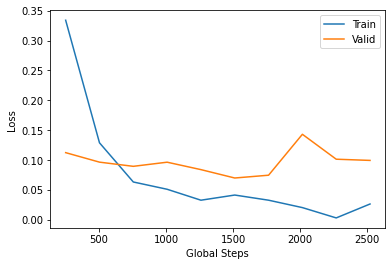

In [21]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [22]:
# Evaluation Function
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (seqs, labels) in test_loader:
            labels = labels.to(device)  
            seqs = seqs.to(device)
            output = model(seqs, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/DL_NLP_marathon/model/Day32_bert//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9712    0.9681    0.9696       626
           0     0.9686    0.9717    0.9701       635

    accuracy                         0.9699      1261
   macro avg     0.9699    0.9699    0.9699      1261
weighted avg     0.9699    0.9699    0.9699      1261



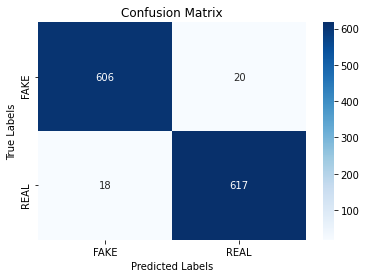

In [40]:
best_model = BERT().to(device)
load_checkpoint(destination_folder + '/model.pt', best_model)
evaluate(best_model, test_iter)